**Module Path**

In [1]:
import os

os.chdir("./../../")

# Temporal-Difference Methods

In this notebook, we will implement many Temporal-Difference (TD) methods.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [2]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use("ggplot")
np.set_printoptions(precision=3, linewidth=120)

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

from examples.cliffwalking.plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
from env import Gym
from policy import RandomPolicy

In [4]:
env = Gym("cliffwalking")

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

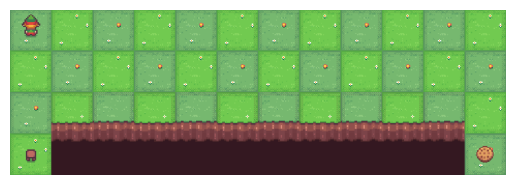

In [5]:
env.watch(RandomPolicy(env.get_action_space()), display)

In [6]:
print(env.get_observation_space())
print(env.get_action_space())

Discrete(48)
Discrete(4)


The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

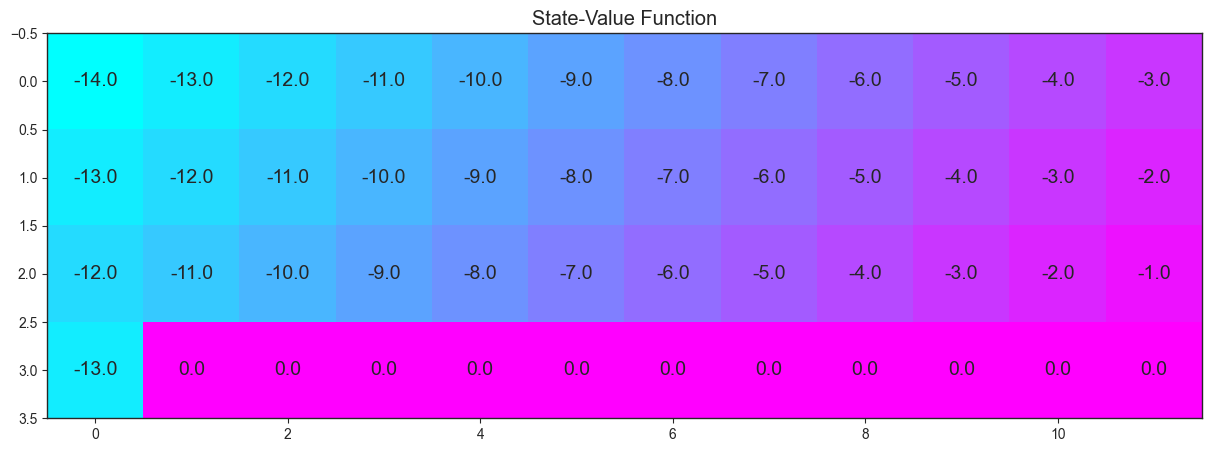

In [7]:
# define the optimal state-value function
V_opt = np.zeros((4, 12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

Let's implement the Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
from qtable import DictionaryQTable
from policy import SarsaPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)
policy = SarsaPolicy(q_table, env.get_action_space())

In [9]:
from train import TrainerTD

trainer = TrainerTD(policy, env)
trainer.train(50_000)

In [10]:
Q_sarsa = q_table.q_values

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  0  0  0  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


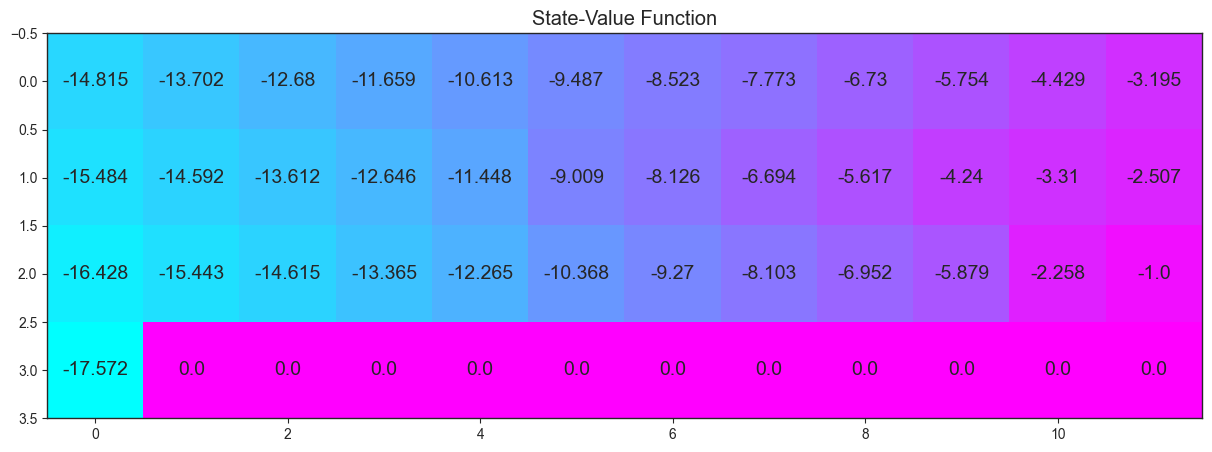

In [11]:
# print the estimated optimal policy
policy_sarsa = np.array(
    [np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]
).reshape(4, 12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = [np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)]
plot_values(V_sarsa)

In [12]:
trainer.evaluate(50_000)

Evaluation: Average reward over 50000 episodes: -21.94966


### Part 2: TD Control: Q-learning

In this section, we will implement of the Q-learning control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [13]:
from policy import SarsaMaxPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)
policy = SarsaMaxPolicy(q_table, env.get_action_space())

trainer = TrainerTD(policy, env)
trainer.train(50_000)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  2  1  1  2  2  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


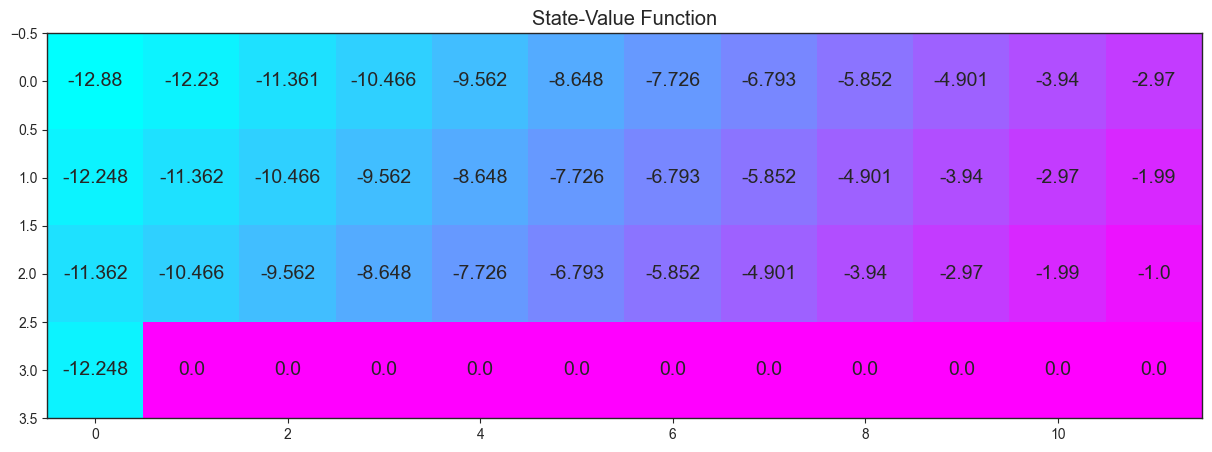

In [14]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_table.q_values

# print the estimated optimal policy
policy_sarsamax = np.array(
    [np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]
).reshape((4, 12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values(
    [np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)]
)

In [15]:
trainer.evaluate(50_000)

Evaluation: Average reward over 50000 episodes: -45.81174


### Part 3: TD Control: Expected Sarsa

In this section, we will implement of the Expected Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [16]:
from policy import SarsaExpectedPolicy

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)
policy = SarsaExpectedPolicy(q_table, env.get_action_space())

trainer = TrainerTD(policy, env)
trainer.train(50_000)

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


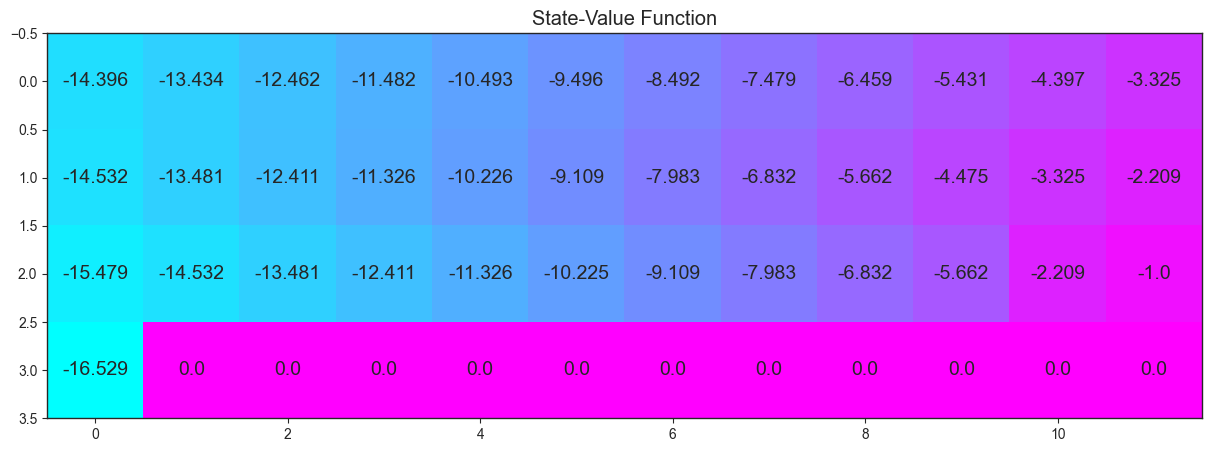

In [17]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = q_table.q_values

# print the estimated optimal policy
policy_expsarsa = np.array(
    [np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]
).reshape(4, 12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values(
    [np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)]
)

In [18]:
trainer.evaluate(50_000)

Evaluation: Average reward over 50000 episodes: -20.69366


Score:  -17


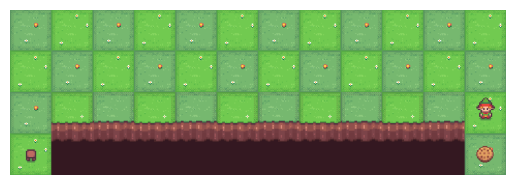

In [19]:
env.watch(policy, display)